# Title: 

In [1]:
# packages

import datetime as dt
from loguru import logger
import numpy as np
import pandas as pd
from tqdm import tqdm

from quantified_strategies import strategy_utils

import constants
import model
import utils

2024-03-02 12:54:07.801 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU
2024-03-02 12:54:08.492 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


In [2]:
import torch
from quantified_strategies import loss

def my_cagr_loss(weights: torch.Tensor, returns: torch.Tensor, **kwargs) -> torch.Tensor:


    port_return = weights * returns
    try:
        port_return = torch.sum(port_return, dim=1)
    except IndexError:
        pass

    long_overnight_costs = loss.calc_long_overnight_cost(weights=weights, long_costs=kwargs.get("long_costs"), n_days=kwargs.get("n_days"))
    short_overnight_costs = loss.calc_short_overnight_cost(weights=weights, short_costs=kwargs.get("short_costs"), n_days=kwargs.get("n_days"))
    overnight_costs = long_overnight_costs + short_overnight_costs
        
    port_return = port_return - overnight_costs

    active_weights = 1 - weights[:, -1]
    active_port_return = port_return[torch.abs(active_weights) > 1e-5]
    mu_return = torch.mean(active_port_return)
    
    std_return = torch.std(active_port_return) if active_port_return.shape[0] > 3 else 0.01
    
    sharpe = mu_return / (std_return + 1e-8)
    multiplier = 252.0 * torch.sum(active_weights) / (len(active_weights) + 1e-8)
    ann_sharpe = sharpe * torch.sqrt(multiplier)
    
    return ann_sharpe

In [3]:
# parameters

# Trading Parameters
ASSETS = ["VUSA.L", "CNX1.L", utils.CASH]
START = dt.date(2012, 1, 1)
END = dt.date.today()

# Algorithm Parameters
LOSS_FUNCTION = my_cagr_loss
MAXIMIZE_LOSS = True
BATCH_SIZE = 64
EPOCHS = 2_000
LEARNING_RATE = 0.0001

# Allocation Parameters
ALLOW_NEGATIVE_WEIGHTS = False
MAX_LEVERAGE_WEIGHT = 1.5
MIN_LEVERAGE_WEIGHT = (MAX_LEVERAGE_WEIGHT - 1) / (len(ASSETS) - 1)
MAX_WEIGHT = MAX_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 1.0
MIN_WEIGHT = MIN_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 0.0

# Other Parameters
STORE = False

# Fetch costs involved in trading assets
LONG_OVERNIGHT_COSTS = [constants.LONG_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]
SHORT_OVERNIGHT_COSTS = [constants.SHORT_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]

In [4]:
def run(N: int = np.inf):

    def train_model(X_train_: pd.DataFrame, y_train_: pd.DataFrame, name: str = None, **other_train):
        
        OUTPUT_SHAPE = y_train_.shape[1]
        INPUT_SHAPE = X_train_.shape[1]

        my_net = model.Net(
            input_shape=INPUT_SHAPE, 
            output_shape=OUTPUT_SHAPE, 
            layer_sizes=[8, 16, 8], 
            allow_negative_weights=ALLOW_NEGATIVE_WEIGHTS, 
            max_weight=MAX_WEIGHT, 
            min_weight=MIN_WEIGHT,
        ).to(device=model.DEVICE)

        model.train(
            net=my_net, 
            name=name,
            X=X_train_, 
            y=y_train_, 
            loss_fn=LOSS_FUNCTION, 
            lr=LEARNING_RATE, 
            batch_size=BATCH_SIZE, 
            epochs=EPOCHS, 
            maximize_loss=MAXIMIZE_LOSS, 
            store=STORE,
            long_costs=LONG_OVERNIGHT_COSTS, 
            short_costs=SHORT_OVERNIGHT_COSTS, 
            # test_size=0.3,
            test_size=0.0,
            patience=20,
            min_delta=0.005,
            **other_train,
        )

        return my_net
        
    # Get data
    X_grouped, y_grouped, other = utils.get_data(assets=ASSETS, start=START, end=END)
    X_raw, y_raw = utils.get_raw_data(assets=ASSETS, is_classification=False, start=START, end=END)

    # Train Model
    my_net = train_model(X_train_=X_grouped, y_train_=y_grouped, name=f"{dt.date.today():%Y%m%d}", **other)
            
    # Apply Model on test data
    strat_dict = utils.run(net=my_net, X_df=X_raw, y_df=y_raw, lost_costs=LONG_OVERNIGHT_COSTS, short_costs=SHORT_OVERNIGHT_COSTS)
    
    return strat_dict
    

In [5]:
latest_strat_dicts = run()

C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\pytorch_nn_asset_allocator\utils.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


Remove ['buy_when_yields_are_low']


C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\pytorch_nn_asset_allocator\utils.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


Remove ['buy_when_yields_are_low']


2024-03-02 12:54:12.825 | INFO     | model:train:93 - Training: '20240302'
2024-03-02 12:54:13.050 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.3580, Val Loss: 1.3580,Hit Rate: 57.19%, Val Hit Rate: 57.19%
2024-03-02 12:54:22.646 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.6373, Val Loss: 1.6373,Hit Rate: 58.44%, Val Hit Rate: 58.44%
2024-03-02 12:54:31.181 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.0493, Val Loss: 2.0493,Hit Rate: 59.62%, Val Hit Rate: 59.62%
2024-03-02 12:54:41.021 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.5059, Val Loss: 2.5059,Hit Rate: 61.67%, Val Hit Rate: 61.67%
2024-03-02 12:54:51.770 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.6647, Val Loss: 2.6647,Hit Rate: 61.98%, Val Hit Rate: 61.98%
2024-03-02 12:55:02.519 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.7296, Val Loss: 2.7296,Hit Rate: 61.82%, Val Hit Rate: 61.82%
2024-03-02 12:55:12.657 | INFO     | model:train:130 - Epoch: 30

In [6]:
# TODO: Fix update dataset to be progressive/sequential

In [7]:
strat_df = latest_strat_dicts["strat"].copy()
benchmark_df = latest_strat_dicts["benchmark"].copy()
hodl_df = latest_strat_dicts["hodl"].copy()

In [15]:
FROM_DATE = dt.date(2013, 1, 1)
TO_DATE = dt.date(2023, 12, 31)
TO_DATE = dt.date.today()

In [16]:
hodl_df_ = hodl_df.loc[(hodl_df.index.date >= FROM_DATE) & (hodl_df.index.date <= TO_DATE)]
benchmark_df_ = benchmark_df.loc[(benchmark_df.index.date >= FROM_DATE) & (benchmark_df.index.date <= TO_DATE)]
strat_df_ = strat_df.loc[(strat_df.index.date >= FROM_DATE) & (strat_df.index.date <= TO_DATE)]

In [17]:
hodl_ret = strategy_utils.get_cumulative_return(returns=hodl_df_["ret"], total=False)
benchmark_ret = strategy_utils.get_cumulative_return(returns=benchmark_df_["ret"], total=False)
strat_ret = strategy_utils.get_cumulative_return(returns=strat_df_["ret"], total=False)

hodl_pos = hodl_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
benchmark_pos = benchmark_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
strat_pos = strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)

In [18]:
import matplotlib.pyplot as plt

<Axes: >

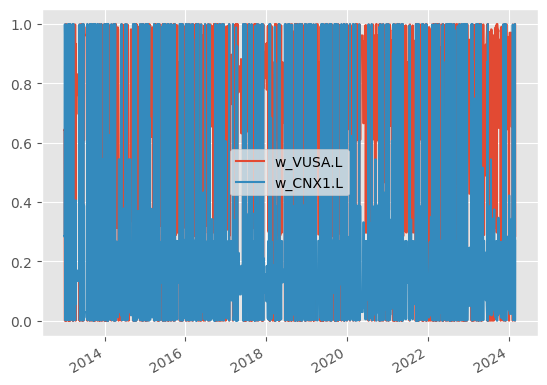

In [19]:
strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].plot()

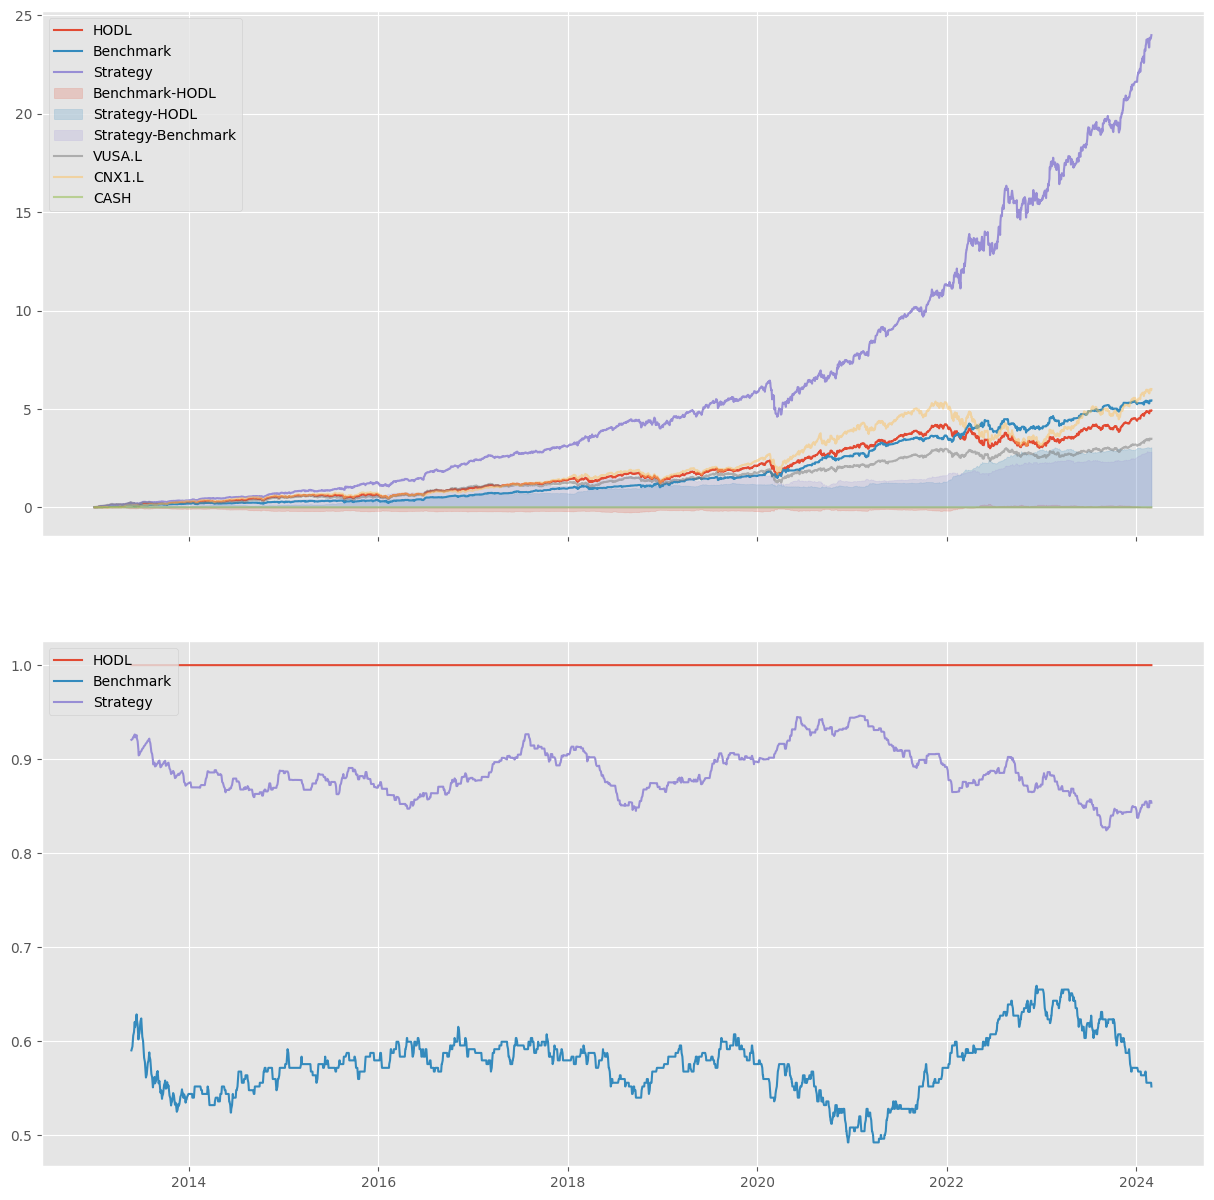

In [20]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(15, 15), sharex="col", nrows=2)

ax[0].plot(hodl_ret, label="HODL", color=colors[0])
ax[0].plot(benchmark_ret, label="Benchmark", color=colors[1])
ax[0].plot(strat_ret, label="Strategy", color=colors[2])

ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=benchmark_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[0],
    alpha=0.2,
    label="Benchmark-HODL",
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[1],
    alpha=0.2,
    label="Strategy-HODL",
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-benchmark_df_["ret"], total=False), 
    color=colors[2],
    alpha=0.2,    
    label="Strategy-Benchmark",
)
for i, asset in enumerate(ASSETS):
    ax[0].plot(strategy_utils.get_cumulative_return(returns=hodl_df_[asset], total=False), label=asset, color=colors[3+i], alpha=0.5)
ax[0].legend(loc="upper left")

# Activity
ax[1].plot(hodl_pos.rolling(window=252, min_periods=100).mean(), label="HODL", color=colors[0])
ax[1].plot(benchmark_pos.rolling(window=252, min_periods=100).mean(), label="Benchmark", color=colors[1])
ax[1].plot(strat_pos.rolling(window=252, min_periods=100).mean(), label="Strategy", color=colors[2])
ax[1].legend(loc="upper left")

plt.show()


In [21]:
desc = pd.concat([
    strategy_utils.describe(returns=strat_df_["ret"], pos=strat_pos, daily=True).to_frame(name="strategy"),
    strategy_utils.describe(returns=benchmark_df_["ret"], pos=benchmark_pos, daily=True).to_frame(name="benchmark"),
    strategy_utils.describe(returns=hodl_df_["ret"], pos=hodl_pos, daily=True).to_frame(name="hodl")
], axis=1)
desc

,strategy,benchmark,hodl
Asset,Undefined,Undefined,Undefined
Start,2013-01-02,2013-01-02,2013-01-02
End,2024-02-28,2024-02-28,2024-02-28
Mean Return,0.11881%,0.12048%,0.06766%
Total Return,"2,399.32%",543.17%,492.07%
Median Return,0.09522%,0.14813%,0.09883%
1st Quartile,-0.32004%,-0.37925%,-0.38213%
3rd Quartile,0.55808%,0.65642%,0.55507%
Std Dev Return,0.94247%,1.03792%,0.94604%
CAGR,11.436 bps,11.510 bps,6.318 bps
